In [ ]:
from pymongo import MongoClient
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import json
import codecs
import numpy as np
from find_exit import FindExit
from density_generation import DMap
from matplotlib import pyplot as plt
from copy import copy
from path_finder import  AStarDynamic, AStarStatic, relocate_paths_xy
from locate_preprocess import relocate_node
%matplotlib inline

In [12]:
from bson.objectid import ObjectId

In [13]:
# get map_data
map_data = pd.read_csv('../map_data/mask_floor0.csv', header=None)
map_data = np.array(-(map_data - 1)).astype(int)
# get exit_list
# 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
exits = pd.read_csv('../map_data/exit_floor0.csv',header=None, )
exits = exits.T

# 坐标-->索引
exits[0] = exits[0].astype(float)
exits[1] = 230 - exits[1].astype(float)

exit_list = np.array(exits.ix[:,[1,0]]) #令0-230的在前面

In [14]:
client = MongoClient()

db = client.mapping

collection = db.people_activity_0524_path

In [15]:
# id_list = []
# for post in collection.find():
#     id_list.append(post['_id'])

In [16]:
record = collection.find_one()

In [17]:
small_cluster = record['small_clusters']

small_cluster = pd.DataFrame(small_cluster)
small_cluster = small_cluster[small_cluster[4] > 0]
small_cluster.index = range(len(small_cluster))

# 坐标-->索引
small_cluster[0] = small_cluster[0] 
small_cluster[1] = 230 - small_cluster[1]

cluster_list = np.array(small_cluster[[1,0]]).astype(int)
cl = zip(cluster_list.tolist(), small_cluster[4]) # cl = [([197, 9], 1.0),...,([],1.0)]

# 创建初始状态密度图
M = DMap(sigma=10)
# density_map这个函数是按照small_cluster的xy写的
# x是0-50,y是0-230
crowd_density = M.density_map(map_data.shape, small_cluster, crowd=True)

# exits_list的x大,y小,所以xy坐标需要换一下位置, 
exits_density = M.density_map(map_data.shape, pd.DataFrame(exit_list[:,[1,0]]), sigma=5)
show_data = (crowd_density-exits_density) # density的图

In [18]:
# find exits for each cluster
exit_finder = FindExit(k_attr=500, k_repul=100,sigma_attr=50, sigma_repul=50)
exits_matched = pd.DataFrame(exit_finder.find_exit_for_all(cl, exit_list.tolist()))

exits_matched = pd.concat([small_cluster, exits_matched], axis=1, ignore_index=True)

start_list1=[relocate_node(tuple(small_cluster[[1,0]].astype(int).iloc[i]), map_data, 1)  for i in range(len(small_cluster))]
#end_list1 = [tuple(exits_matched[[6,7]].astype(int).iloc[i]+2) for i in range(len(exits_matched))]
 
start_end = zip(start_list1, end_list1)


0
10
20
30
0:00:10.589422


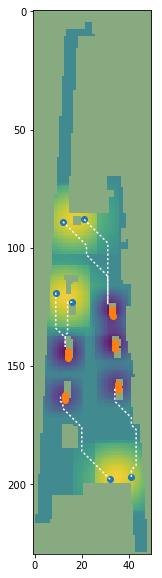

In [20]:
#small_cluster2 = small_cluster.copy()
finder = AStarDynamic(map_data, small_cluster, exit_list,)

paths_sep = finder.find_paths(start_list1, end_list1, print_or_not=True, weight_d=1)

paths_sep = finder.clean_paths_sep(paths_sep)
#_____________________________________________________________
plt.rcParams['figure.figsize'] = (10,10) 

plt.scatter( small_cluster[0], small_cluster[1],)

plt.scatter(exits[0], exits[1])

# 画出路径
for p in paths_sep:
    p = np.array(p).T
    plt.plot(p[0], p[1],c='w', linestyle=':' )

show_data = crowd_density-exits_density
masked_data = np.ma.masked_where(map_data==1, show_data)

plt.imshow(map_data, cmap='PiYG',alpha=0.55)
plt.imshow(masked_data, interpolation='none', alpha=0.8)